In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import pandas as pd
from openpyxl import load_workbook

plt.style.use('ggplot')

Se dispone de una viga simplemente apoyada de longitud `L = 0.1 * X`, la cual se encuentra sometida a una carga distribuida `W = 2 * X`. La viga tiene una sección transversal compuesta por una sección cuadrada de pared delgada y se encuentra conectada a una placa mediante pernos. Determine la separación `s` a la cual se debe colocar los pernos acorde con los datos de la tabla en Excel.
<h1 style="text-align: center">VIGA ANÁLISIS</h1>
<img src="cortante1.png"/>
<h1 style="text-align: center">SECCIÓN TRANSVERSAL</h1>
<img src="cortante2.png" />

In [38]:
codigo = "2170249"
X = sum([int(i) for i in codigo])
b_perfil = X * 10
t = 10
b_placa = b_perfil + 2 * X
h_total = b_perfil + t
# Newtons
Ay, By, x, Y = sp.symbols("Ay By x Y")
W = 2 * X
L = X * 0.1
V = 50 * 10 ** 3

# Equilibrio

In [17]:
equilibrio_momentos = By * L - W * L ** 2 / 2
ecuacion_momentos = sp.Eq(equilibrio_momentos, 0)
reaccion_By = sp.solve(ecuacion_momentos)[0]
# kN
reaccion_By

62.5000000000000

In [19]:
equilibrio_y = Ay + By - W * L
ecuacion_y = sp.Eq(equilibrio_y.subs(By, reaccion_By), 0)
reaccion_Ay = sp.solve(ecuacion_y)[0]
# en kN
reaccion_Ay

62.5000000000000

# Diagrama de fuerza cortante

In [22]:
# Tramo1 0 < x < L
funcion_w = W
cortante_1 = reaccion_Ay - sp.integrate(funcion_w, x)
cortante_1

62.5 - 50*x

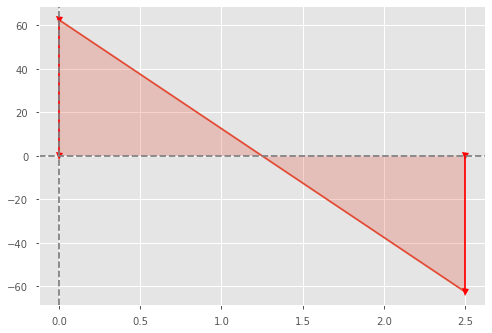

In [29]:
x_array = np.arange(0, L + 0.005, 0.005)
dfc = sp.lambdify(x, cortante_1)(x_array)
plt.plot(x_array, dfc)
plt.fill_between(x_array, dfc, alpha=0.25)
# comprobar que el diagrama cierra colocando dos plots con la fuerza en cada extremo
plt.plot([0, 0], [0, float(reaccion_Ay)], marker="v", color="red")
plt.plot([L, L], [0, -reaccion_By], marker="v", color="red")
# graficar ejes
plt.axvline(0, color="gray", linestyle='--')
plt.axhline(0, color="gray", linestyle='--')

# Obtener cortante máximo

In [31]:
def obtener_maximo(valores_diagrama):
    valor_max_positivo = np.amax(valores_diagrama)
    valor_max_negativo = np.amin(valores_diagrama)

    valor_maximo = valor_max_positivo
    if np.absolute(valor_max_negativo) > valor_max_positivo:
        valor_maximo = valor_max_negativo
    
    posicion = x_array[np.where(valores_diagrama == valor_maximo)][0]
    return valor_maximo, posicion

cortante_maximo, posicion_cortante_maximo = obtener_maximo(dfc)
print(f"El valor del cortante máximo es de {cortante_maximo} kN")
print(f"Se encuentra localizado a {posicion_cortante_maximo} metros desde el nodo A")

El valor del cortante máximo es de 62.5 kN
Se encuentra localizado a 0.0 metros desde el nodo A


# Determinar distribución de pernos

In [39]:
A = b_perfil * b_perfil - (b_perfil - 2 * t) * (b_perfil - 2 * t) + b_placa * t
y = ((((b_perfil ** 2) - (b_perfil - 2 * t) ** 2) * b_perfil / 2) + b_placa * t * (b_perfil + t / 2)) / A
# mm ^ 4
Iz = b_perfil ** 4 / 12 - (b_perfil - 2 * t) ** 4 / 12 +  b_placa * t ** 3 / 12 + ((b_perfil ** 2) - (b_perfil - 2 * t) ** 2) * (y - b_perfil / 2) + b_placa * t * (b_perfil + t / 2 - y) ** 2
# mm ^ 3
Q = b_placa * t * (h_total - y - t / 2)

In [40]:
q = cortante_maximo * 10 ** 3 * Q / Iz
# N / mm
q

152.13325089531537

In [44]:
# Diagrama de esfuerzo cortante
# Tramo1 h tot - y_trazo - t < Y < h tot - y_trazo
Q_y = b_placa * (h_total - y - Y) * ((h_total - y - Y) / 2 + Y)
esfuerzo_cortante_1 = cortante_maximo * 10 ** 3 * Q_y / (Iz * b_perfil)

In [45]:
# Diagrama de esfuerzo cortante
# Tramo2 h tot - y_trazo - 2t < Y < h tot - y_trazo - t
Q_y_2 = 2 * t * (h_total - y - 2 * t - Y) * ((h_total - y - 2 * t - Y) / 2 + Y)
esfuerzo_cortante_2 = cortante_maximo * 10 ** 3 * Q_y_2 / (Iz * b_perfil)

In [46]:
# Diagrama de esfuerzo cortante
# Tramo2 - y_trazo - t < Y <  h tot - y_trazo - 2t
Q_y_3 = b_perfil * (h_total - y - t - Y) * ((h_total - y - t - Y) / 2 + Y)
esfuerzo_cortante_3 = cortante_maximo * 10 ** 3 * Q_y_3 / (Iz * b_perfil)

In [47]:
# Diagrama de esfuerzo cortante
# Tramo2 - y_trazo < Y < - y_trazo - t
Q_y_4 = b_perfil * (y + Y) * ((-y - Y) / 2 + Y)
esfuerzo_cortante_4 = cortante_maximo * 10 ** 3 * Q_y_4 / (Iz * b_perfil)

In [5]:
pernos = pd.read_excel('cortante.xlsx', usecols="B:H", skiprows=3, nrows=8, index_col='No.')
pernos

,dp [in],A [mm ^ 2],Esf Adm [MPa],dh [mm],S mín [mm],Le [mm]
No.,,,,,,
4.0,"1/2""",127.0,35.3,14.3,40.0,20.0
5.0,"5/8""",198.0,55.2,17.5,50.0,25.0
6.0,"3/4""",285.0,79.5,20.6,60.0,30.0
7.0,"7/8""",388.0,108.2,23.8,70.0,35.0
8.0,"1""",507.0,141.4,28.6,80.0,40.0
9.0,"1 1/8""",641.0,178.9,31.8,90.0,45.0
10.0,"1 1/4""",792.0,220.9,34.9,100.0,50.0
NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
pernos["F Adm [N]"] =  pernos["Esf Adm [MPa]"] * pernos["A [mm ^ 2]"]
pernos

,dp [in],A [mm ^ 2],Esf Adm [MPa],dh [mm],S mín [mm],Le [mm],F Adm [N]
No.,,,,,,,
4.0,"1/2""",127.0,35.3,14.3,40.0,20.0,4483.1
5.0,"5/8""",198.0,55.2,17.5,50.0,25.0,10929.6
6.0,"3/4""",285.0,79.5,20.6,60.0,30.0,22657.5
7.0,"7/8""",388.0,108.2,23.8,70.0,35.0,41981.6
8.0,"1""",507.0,141.4,28.6,80.0,40.0,71689.8
9.0,"1 1/8""",641.0,178.9,31.8,90.0,45.0,114674.9
10.0,"1 1/4""",792.0,220.9,34.9,100.0,50.0,174952.8
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
pernos["S Calculada [mm]"] =  pernos["F Adm [N]"] / q
pernos["Le Calculado [mm]"] =  pernos["S Calculada [mm]"] / 2
pernos

,dp [in],A [mm ^ 2],Esf Adm [MPa],dh [mm],S mín [mm],Le [mm],F Adm [N],S Calculada [mm],Le Calculado [mm]
No.,,,,,,,,,
4.0,"1/2""",127.0,35.3,14.3,40.0,20.0,4483.1,36.835307,18.417653
5.0,"5/8""",198.0,55.2,17.5,50.0,25.0,10929.6,89.802853,44.901427
6.0,"3/4""",285.0,79.5,20.6,60.0,30.0,22657.5,186.164923,93.082462
7.0,"7/8""",388.0,108.2,23.8,70.0,35.0,41981.6,344.941028,172.470514
8.0,"1""",507.0,141.4,28.6,80.0,40.0,71689.8,589.037896,294.518948
9.0,"1 1/8""",641.0,178.9,31.8,90.0,45.0,114674.9,942.224163,471.112082
10.0,"1 1/4""",792.0,220.9,34.9,100.0,50.0,174952.8,1437.496397,718.748198
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
filtro = (pernos["S Calculada [mm]"] >= pernos["S mín [mm]"]) & (pernos["Le Calculado [mm]"] >= pernos["Le [mm]"])
pernos[filtro]

,dp [in],A [mm ^ 2],Esf Adm [MPa],dh [mm],S mín [mm],Le [mm],F Adm [N],S Calculada [mm],Le Calculado [mm]
No.,,,,,,,,,
5.0,"5/8""",198.0,55.2,17.5,50.0,25.0,10929.6,89.802853,44.901427
6.0,"3/4""",285.0,79.5,20.6,60.0,30.0,22657.5,186.164923,93.082462
7.0,"7/8""",388.0,108.2,23.8,70.0,35.0,41981.6,344.941028,172.470514
8.0,"1""",507.0,141.4,28.6,80.0,40.0,71689.8,589.037896,294.518948
9.0,"1 1/8""",641.0,178.9,31.8,90.0,45.0,114674.9,942.224163,471.112082
10.0,"1 1/4""",792.0,220.9,34.9,100.0,50.0,174952.8,1437.496397,718.748198


In [9]:
pernos_cumplen = pernos.loc[filtro, "S Calculada [mm]"] - pernos.loc[filtro, "S mín [mm]"]
indice = pernos_cumplen.idxmin()
indice

5.0

In [10]:
respuesta = pernos.loc[[indice], ['dp [in]', 'dh [mm]', 'S Calculada [mm]', 'Le Calculado [mm]']]
respuesta

,dp [in],dh [mm],S Calculada [mm],Le Calculado [mm]
No.,,,,
5.0,"5/8""",17.5,89.802853,44.901427


In [11]:
with pd.ExcelWriter('cortante.xlsx', mode='a', engine='openpyxl') as writer:  
    # configurando sheets
    book = load_workbook('cortante.xlsx')
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
    
    # colcando los dataframes en sus respectivas posiciones
    respuesta.to_excel(writer, startrow=15, startcol=2, sheet_name='Pernos')
